In [1]:
def generate_floorplan(Nx, Ny, tx, ty, tsvy):
    floorplan = []
    tsvx = Nx * tx  # Calculate the width of the TSV based on the number of tiles and the width of each tile
    
    # Generate the floorplan
    for y in range(Ny):
        # Calculate the bottom y-coordinate of the current row of tiles and TSV
        bottom_y_tiles = y * (ty + tsvy)
        bottom_y_tsv = bottom_y_tiles + ty
        
        # Add Nx tiles to the floorplan
        for i in range(Nx):
            left_x = i * tx  # Calculate the left x-coordinate of the current tile
            unit_name = f"tile{y*Nx+i+1}"
            floorplan.append(f"{unit_name}\t{tx}\t{ty}\t{left_x}\t{bottom_y_tiles}")
        
        # Add one TSV above the tiles in the current row
        unit_name_tsv = f"tsv{y+1}"
        floorplan.append(f"{unit_name_tsv}\t{tsvx}\t{tsvy}\t{0.0}\t{bottom_y_tsv}")

    # Save to a text file
    with open('floorplan.txt', 'w') as file:
        file.write("\n".join(floorplan))
    
    return "Floorplan generated and saved to 'floorplan.txt'."

# Parameters
Nx = 3
Ny = 4
tx = 0.002
ty = 0.002
tsvy = 0.0003

# Generate the floorplan
generate_floorplan(Nx, Ny, tx, ty, tsvy)


"Floorplan generated and saved to 'floorplan.txt'."

Power trace generation  

In [2]:
import math
tile_power = 0.001

##write a function to generate the number of tiles required for each layer and depending on the utilization of the tile determine the power consumed by the tile
tile_dict = {}
def generate_tile_power(crxb_size, cell_res, weight_res,layer_name, layer_size, pe_row, pe_col, array_row, array_col, tile_power):
    if layer_name == "conv":
        ##find the required number of crxb
        weight_shape = layer_size
        num_xbs_along_col = math.ceil(weight_shape[0]*weight_res/cell_res)
        num_xbs_along_row = math.ceil(weight_shape[1]*weight_shape[2]*weight_shape[3]/crxb_size)
        num_pe_row = math.ceil(num_xbs_along_row/array_row)
        num_pe_col = math.ceil(num_xbs_along_col/array_col)
        num_tile_row = math.ceil(num_pe_row/pe_row)
        num_tile_col = math.ceil(num_pe_col/pe_col)
        num_tiles = num_tile_row*num_tile_col

        ## find the utilization rate of the each tile
        num_elements_in_xb = crxb_size*crxb_size*weight_res/cell_res
        num_elements_layer = weight_shape[0]*weight_shape[1]*weight_shape[2]*weight_shape[3]
        for i in range(num_tiles):
            if num_elements_layer > num_elements_in_xb:
                tile_utilization = 1.0
            else:
                tile_utilization = num_elements_layer/num_elements_in_xb
            num_elements_layer = num_elements_layer - num_elements_in_xb
        
        

        for i in range(num_tiles):
            tile_dict["tile"+str(i)] = tile_power
    elif layer_name == "fc":
        weight_shape = layer_size
        num_xbs_along_col = math.ceil(weight_shape[0]*weight_res/cell_res)
        num_xbs_along_row = math.ceil(weight_shape[1]/crxb_size)
        num_pe_row = math.ceil(num_xbs_along_row/array_row)
        num_pe_col = math.ceil(num_xbs_along_col/array_col)
        num_tile_row = math.ceil(num_pe_row/pe_row)
        num_tile_col = math.ceil(num_pe_col/pe_col)
        num_tiles = num_tile_row*num_tile_col
        for i in range(num_tiles):
            tile_dict["tile"+str(i)] = tile_power

        

In [3]:
#write a torch neural network model to generate the layer size
import torch
import torch.nn as nn
# Define the LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # First convolutional layer with activation and pooling
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        
        # Second convolutional layer with activation and pooling
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16*4*4)
        
        # Fully connected layers with activation
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
model = LeNet()

print(model)
for name,module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        param = module.weight.shape

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
import math

tile_power = 0.33  # Base power consumption of a tile when fully utilized
tile_dict = {}
def generate_tile_power(crxb_size, cell_res, weight_res, layer_name, layer_size, pe_row, pe_col, array_row, array_col, tile_dict, tile_power, tile_start_idx=0):
    
    
    if layer_name == "conv":
        # Calculate required number of crossbars (Xbars)
        weight_shape = layer_size  # Assuming weight_shape is a tuple (out_channels, in_channels, kernel_height, kernel_width)
        num_xbs_along_col = math.ceil(weight_shape[0] * (weight_res / cell_res)/crxb_size)
        num_xbs_along_row = math.ceil(weight_shape[1] * weight_shape[2] * weight_shape[3] / crxb_size)
        num_xbs_in_tile_row = pe_row * array_row
        num_xbs_in_tile_col = pe_col * array_col
        num_tile_row = math.ceil(num_xbs_along_row / num_xbs_in_tile_row)
        num_tile_col = math.ceil(num_xbs_along_col / num_xbs_in_tile_col)
        num_tiles = num_tile_row * num_tile_col
        # print(num_tiles)
        # Find the utilization rate of each tile
        num_elements_in_xb_in_tile = crxb_size * (crxb_size/(weight_res / cell_res))*pe_col*pe_row*array_row*array_col    
        num_elements_layer = weight_shape[0] * weight_shape[1] * weight_shape[2] * weight_shape[3] 
        total_num_elements = num_elements_layer  # Store the total number of elements to calculate the last tile utilization
        tiles_utilization = []
        num_elements_along_row = weight_shape[1] * weight_shape[2] * weight_shape[3]
        num_elements_along_col = weight_shape[0] * (weight_res / cell_res)
        num_elements_in_tile_along_row = pe_row * array_row * crxb_size
        num_elements_in_tile_along_col = pe_col * array_col * crxb_size

        for i in range(num_tile_row):
            for j in range(num_tile_col):
                if num_elements_along_row > 0 and num_elements_along_col > 0:
                    if num_elements_along_row * num_elements_along_col > num_elements_in_tile_along_row * num_elements_in_tile_along_col:
                        tile_utilization = 1.0
                        num_elements_along_col = num_elements_along_col - num_elements_in_tile_along_col
                    else:
                        tile_utilization = (num_elements_along_row * num_elements_along_col) / (num_elements_in_tile_along_row * num_elements_in_tile_along_col)
                        # print('tile_utilization',tile_utilization)
                    tiles_utilization.append(tile_utilization)
            num_elements_along_row = num_elements_along_row - num_elements_in_tile_along_row
                
        # Calculate power for each tile based on utilization
        for i, utilization in enumerate(tiles_utilization):
            tile_dict[f"tile{tile_start_idx+i+1}"] = round(utilization * tile_power, 5)

    elif layer_name == "fc":
        # Similar calculations for fully connected layers
        weight_shape = layer_size  # Assuming weight_shape is a tuple (out_features, in_features)
        num_xbs_along_col = math.ceil(weight_shape[0] * weight_res / cell_res/crxb_size)
        num_xbs_along_row = math.ceil(weight_shape[1] / crxb_size)
        num_xbs_in_tile_row = pe_row * array_row
        num_xbs_in_tile_col = pe_col * array_col
        num_tile_row = math.ceil(num_xbs_along_row / num_xbs_in_tile_row)
        num_tile_col = math.ceil(num_xbs_along_col / num_xbs_in_tile_col)
        num_tiles = num_tile_row * num_tile_col
        # num_tiles = num_tile_row * num_tile_col
        # print(num_tiles)
        tiles_utilization = []
        num_elements_along_row = weight_shape[1] 
        num_elements_along_col = weight_shape[0] * (weight_res / cell_res)
        num_elements_in_tile_along_row = pe_row * array_row * crxb_size
        num_elements_in_tile_along_col = pe_col * array_col * crxb_size

        for i in range(num_tile_row):
            for j in range(num_tile_col):
                if num_elements_along_row > 0 and num_elements_along_col > 0:
                    if num_elements_along_row * num_elements_along_col > num_elements_in_tile_along_row * num_elements_in_tile_along_col:
                        tile_utilization = 1.0
                        num_elements_along_col = num_elements_along_col - num_elements_in_tile_along_col
                    else:
                        tile_utilization = (num_elements_along_row * num_elements_along_col) / (num_elements_in_tile_along_row * num_elements_in_tile_along_col)
                        # print('tile_utilization',tile_utilization)
                    tiles_utilization.append(tile_utilization)
            num_elements_along_row = num_elements_along_row - num_elements_in_tile_along_row

        # Calculate power for each tile based on utilization
        for i, utilization in enumerate(tiles_utilization):
            tile_dict[f"tile{tile_start_idx+i+1}"] = round(utilization * tile_power, 5)

    return num_tiles
def pad_tile(d, k):
    # Extract suffixes where keys match 'tile{number}' and compute the maximum
    suffixes = [int(key[4:]) for key in d if key.startswith('tile')]
    highest_key = max(suffixes) if suffixes else 0

    # Calculate how many dummy keys are needed
    dummy_keys_needed = (k - (len(d) % k)) % k

    # Add dummy keys continuing from the last key number
    for i in range(1, dummy_keys_needed + 1):
        d[f"tile{highest_key + i}"] = 0

    return d

# Example usage:
crxb_size = 128
cell_res = 2
weight_res = 8
layer_name = "fc"
layer_size = (120,256)  # Out_channels, In_channels, Kernel_height, Kernel_width
pe_row = 3
pe_col = 2
array_row = 2
array_col = 2

tile_powers = generate_tile_power(crxb_size, cell_res, weight_res, layer_name, layer_size, pe_row, pe_col, array_row, array_col, tile_dict, tile_power, tile_start_idx=0)
# for tile, power in tile_powers.items():
#     print(f"{tile}: {power:.6f} W")
print(tile_powers)
print(tile_dict)

1
{'tile1': 0.10313}


In [5]:

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        layer_shape = module.weight.shape
        print(layer_shape)
        num_tile = generate_tile_power(crxb_size, cell_res, weight_res, "conv", layer_shape, pe_row, pe_col, array_row, array_col, tile_dict, tile_power, tile_start_idx)
        tile_start_idx += num_tile
    elif isinstance(module, nn.Linear):
        layer_shape = module.weight.shape
        print(layer_shape)
        num_tile = generate_tile_power(crxb_size, cell_res, weight_res, "fc", layer_shape, pe_row, pe_col, array_row, array_col,  tile_dict, tile_power, tile_start_idx)
        tile_start_idx += num_tile
updated_tile_dict = pad_tile(tile_dict, Nx)
print(tile_dict)

torch.Size([6, 1, 5, 5])
torch.Size([16, 6, 5, 5])
torch.Size([120, 256])
torch.Size([84, 120])
torch.Size([10, 84])
{'tile1': 0.0005, 'tile2': 0.00806, 'tile3': 0.10313, 'tile4': 0.03384, 'tile5': 0.00282, 'tile6': 0}


ADD TSV power trace. 

In [6]:
def add_keys_based_on_name(d, base_name,len, tile_power):
    # Count the current number of keys
    current_key_count = len
    
    # Add additional keys based on the base name and the current key count
    for i in range(1, current_key_count + 1):
        new_key = f"{base_name}{i}"  # Construct the new key name
        d[new_key] = tile_power  # Initialize with a default value (e.g., 0)

    return d

tsv_dict = {}
length = len(tile_dict)
tsv_dict = add_keys_based_on_name(updated_tile_dict, "tsv",length, 0)
mem_tile_power = 0.15
mem_tile_d = {}
mem_tile_d = add_keys_based_on_name(tsv_dict, "memtile",length, mem_tile_power)
mem_tile_tsv = {}
mem_tile_tsv = add_keys_based_on_name(mem_tile_d, "memtsv",length, 0)
print(tsv_dict)

{'tile1': 0.0005, 'tile2': 0.00806, 'tile3': 0.10313, 'tile4': 0.03384, 'tile5': 0.00282, 'tile6': 0, 'tsv1': 0, 'tsv2': 0, 'tsv3': 0, 'tsv4': 0, 'tsv5': 0, 'tsv6': 0, 'mem_tile1': 0.15, 'mem_tile2': 0.15, 'mem_tile3': 0.15, 'mem_tile4': 0.15, 'mem_tile5': 0.15, 'mem_tile6': 0.15, 'memtsv1': 0, 'memtsv2': 0, 'memtsv3': 0, 'memtsv4': 0, 'memtsv5': 0, 'memtsv6': 0}


In [7]:
print(mem_tile_tsv)

{'tile1': 0.0005, 'tile2': 0.00806, 'tile3': 0.10313, 'tile4': 0.03384, 'tile5': 0.00282, 'tile6': 0, 'tsv1': 0, 'tsv2': 0, 'tsv3': 0, 'tsv4': 0, 'tsv5': 0, 'tsv6': 0, 'mem_tile1': 0.15, 'mem_tile2': 0.15, 'mem_tile3': 0.15, 'mem_tile4': 0.15, 'mem_tile5': 0.15, 'mem_tile6': 0.15, 'memtsv1': 0, 'memtsv2': 0, 'memtsv3': 0, 'memtsv4': 0, 'memtsv5': 0, 'memtsv6': 0}


In [12]:
def write_dict_to_file(d, filename):
    # Open the file for writing
    with open(filename, 'w') as file:
        # Write the keys on the first row separated by tabs
        file.write('\t'.join(d.keys()) + '\n')
        # Write the values on the second row, converting all values to strings and separating by tabs
        file.write('\t'.join(map(str, d.values())) + '\n')

# Filename to write to
filename = 'output.ptrace'
# Write the dictionary to the file
write_dict_to_file(tsv_dict, filename)


Memory size requirements. 
1,2,3,4,5,6,7,8,9,10    

In [1]:
fault_covergae = [1,2,3,4,5,6,7,8,9,10,15,20,30,35,40] #in percentage
crxb_size = 128
cell_res = 2
tile_start_idx=0
tile_dict = {}
crxb_size = 128
cell_res = 2
weight_res = 8
pe_row = 3
pe_col = 4
array_row = 2
array_col = 4

crxb_memory = crxb_size*crxb_size*cell_res/8/1024 #in KB
bits_to_store_error = 17 #in bits ( 7 row + 7 col + 3 value)
element_size = crxb_size*crxb_size
num_xb_in_tile = pe_col*pe_row*array_row*array_col
def memory_requirement(fault_coverage, element_size, bits_to_store_error,num_xb_in_tile):
    memory = {}
    for i in fault_coverage:
        memory[f'{i}']= (element_size*i*bits_to_store_error*num_xb_in_tile/100/8) #in B
    return memory
print(fault_covergae)
print(memory_requirement(fault_covergae, element_size, bits_to_store_error, num_xb_in_tile))
print(memory_requirement(fault_covergae, element_size, bits_to_store_error, 1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 35, 40]
{'1': 33423.36, '2': 66846.72, '3': 100270.08, '4': 133693.44, '5': 167116.8, '6': 200540.16, '7': 233963.52, '8': 267386.88, '9': 300810.24, '10': 334233.6, '15': 501350.4, '20': 668467.2, '30': 1002700.8, '35': 1169817.6, '40': 1336934.4}
{'1': 348.16, '2': 696.32, '3': 1044.48, '4': 1392.64, '5': 1740.8, '6': 2088.96, '7': 2437.12, '8': 2785.28, '9': 3133.44, '10': 3481.6, '15': 5222.4, '20': 6963.2, '30': 10444.8, '35': 12185.6, '40': 13926.4}


In [10]:
error_memory = {'1': 8355.84, '2': 16711.68, '3': 25067.52, '4': 33423.36, '5': 41779.2, '6': 50135.04, '7': 58490.88, '8': 66846.72, '9': 75202.56, '10': 83558.4}


In [11]:

        
    # print(name, layer)
    # print(name, layer.size())

In [6]:
import re
def extract_max_value(filename):
    pattern = re.compile(r'layer_1_tile\d+\s+(\d+\.\d+)')
    max_value = float('-inf')

    with open(filename, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                value = float(match.group(1))
                if value > max_value:
                    max_value = value

    return max_value

filename = '../vgg16/outputs/example.steady'
max_value = extract_max_value(filename)
print(f"The maximum value is: {max_value}")

The maximum value is: 344.66


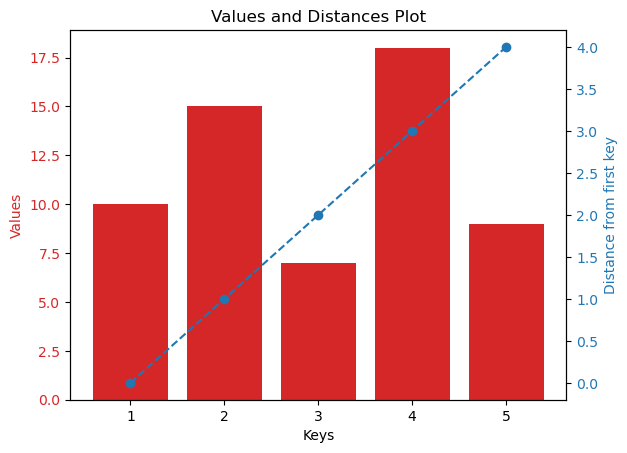

In [7]:
import matplotlib.pyplot as plt

# Example dictionary
data = {'1': 10, '2': 15, '3': 7, '4': 18, '5': 9}

# Convert keys to integers if they are strings and sort by keys
sorted_keys = sorted(data, key=int)
sorted_values = [data[key] for key in sorted_keys]

# Calculate distances from the first key
distances = [int(key) - int(sorted_keys[0]) for key in sorted_keys]

# Plotting the values
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Keys')
ax1.set_ylabel('Values', color=color)
ax1.bar(sorted_keys, sorted_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Distance from first key', color=color)
ax2.plot(sorted_keys, distances, color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Values and Distances Plot')
plt.show()


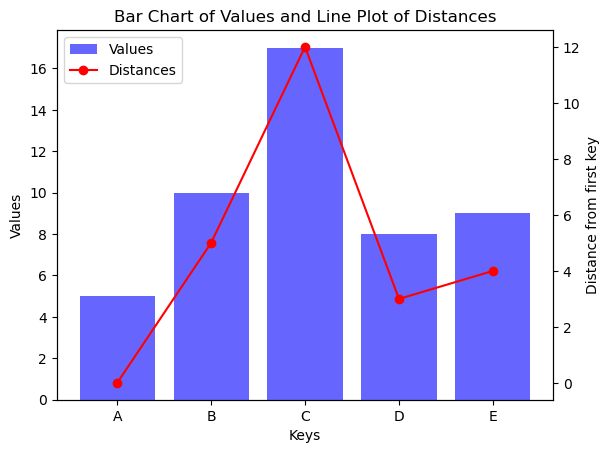

In [10]:
import matplotlib.pyplot as plt

# Data dictionary
data_dict = {'A': 5, 'B': 10, 'C': 17, 'D': 8, 'E': 9}

# Calculate distances from the first key's value
first_value = list(data_dict.values())[0]
distance = {key: value - first_value for key, value in data_dict.items()}

# Keys and values for plotting
keys = list(data_dict.keys())
values = list(data_dict.values())
distances = list(distance.values())

# Create figure and axes
fig, ax1 = plt.subplots()

# Plotting the original values with bars
bars = ax1.bar(keys, values, color='b', label='Values', alpha=0.6)

# Adding labels and title to the first axis
ax1.set_xlabel('Keys')
ax1.set_ylabel('Values')
ax1.set_title('Bar Chart of Values and Line Plot of Distances')

# Create a second y-axis for the distances
ax2 = ax1.twinx()
line = ax2.plot(keys, distances, 'r-o', label='Distances')

# Setting the second y-axis label
ax2.set_ylabel('Distance from first key')

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show plot
plt.show()
